In [1]:
import copy
import time

import numpy as np
import pandas as pd
import textwrap

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

import utility as util
from helpers import imagenet_idx_to_label

In [2]:
args = util.AttrDict(epochs=5, print_every=100, batch_size=32,
        learning_rate=0.01, output_size=10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Using device: cuda:0


In [3]:
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Training set: {len(trainset)} samples, {len(trainloader)} batches")
print(f"Test set has {len(testset)} samples, {len(testloader)} batches")

Files already downloaded and verified
Files already downloaded and verified
Training set: 50000 samples, 1563 batches
Test set has 10000 samples, 313 batches


  cat   cat horse   car   car  deer truck plane horse  ship  bird   car   car truck  frog truck   cat  deer plane truck  deer  deer  deer horse truck   car   dog  frog horse horse truck   car


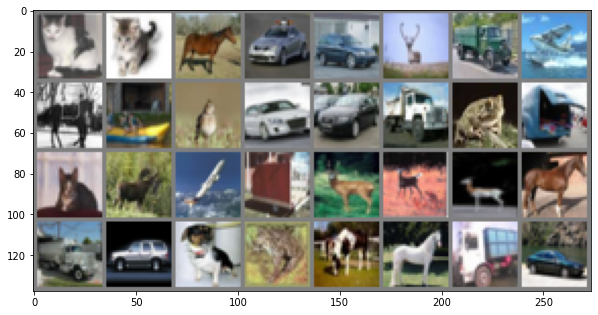

In [4]:
# functions to show an image
def imshow(img):
    # Un-normalize data.
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

plt.figure(figsize=(10, 10))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(args.batch_size)))

## Inspecting MobileNet V3 (small)

In [5]:
mobilenet = torchvision.models.mobilenet_v3_small(pretrained=True, progress=True)
mobilenet = mobilenet.to(device)

In [6]:
col_names = ("input_size", "output_size", "num_params", "kernel_size")#, "mult_adds",)
torchinfo.summary(mobilenet, input_size=(1, 3, 32, 32), col_names=col_names, col_width=18)

Layer (type:depth-idx)                        Input Shape        Output Shape       Param #            Kernel Shape
MobileNetV3                                   --                 --                 --                 --
├─Sequential: 1-1                             [1, 3, 32, 32]     [1, 576, 1, 1]     --                 --
│    └─ConvBNActivation: 2-1                  [1, 3, 32, 32]     [1, 16, 16, 16]    --                 --
│    │    └─Conv2d: 3-1                       [1, 3, 32, 32]     [1, 16, 16, 16]    432                [3, 16, 3, 3]
│    │    └─BatchNorm2d: 3-2                  [1, 16, 16, 16]    [1, 16, 16, 16]    32                 [16]
│    │    └─Hardswish: 3-3                    [1, 16, 16, 16]    [1, 16, 16, 16]    --                 --
│    └─InvertedResidual: 2-2                  [1, 16, 16, 16]    [1, 16, 8, 8]      --                 --
│    │    └─Sequential: 3-4                   [1, 16, 16, 16]    [1, 16, 8, 8]      744                --
│    └─InvertedResidual

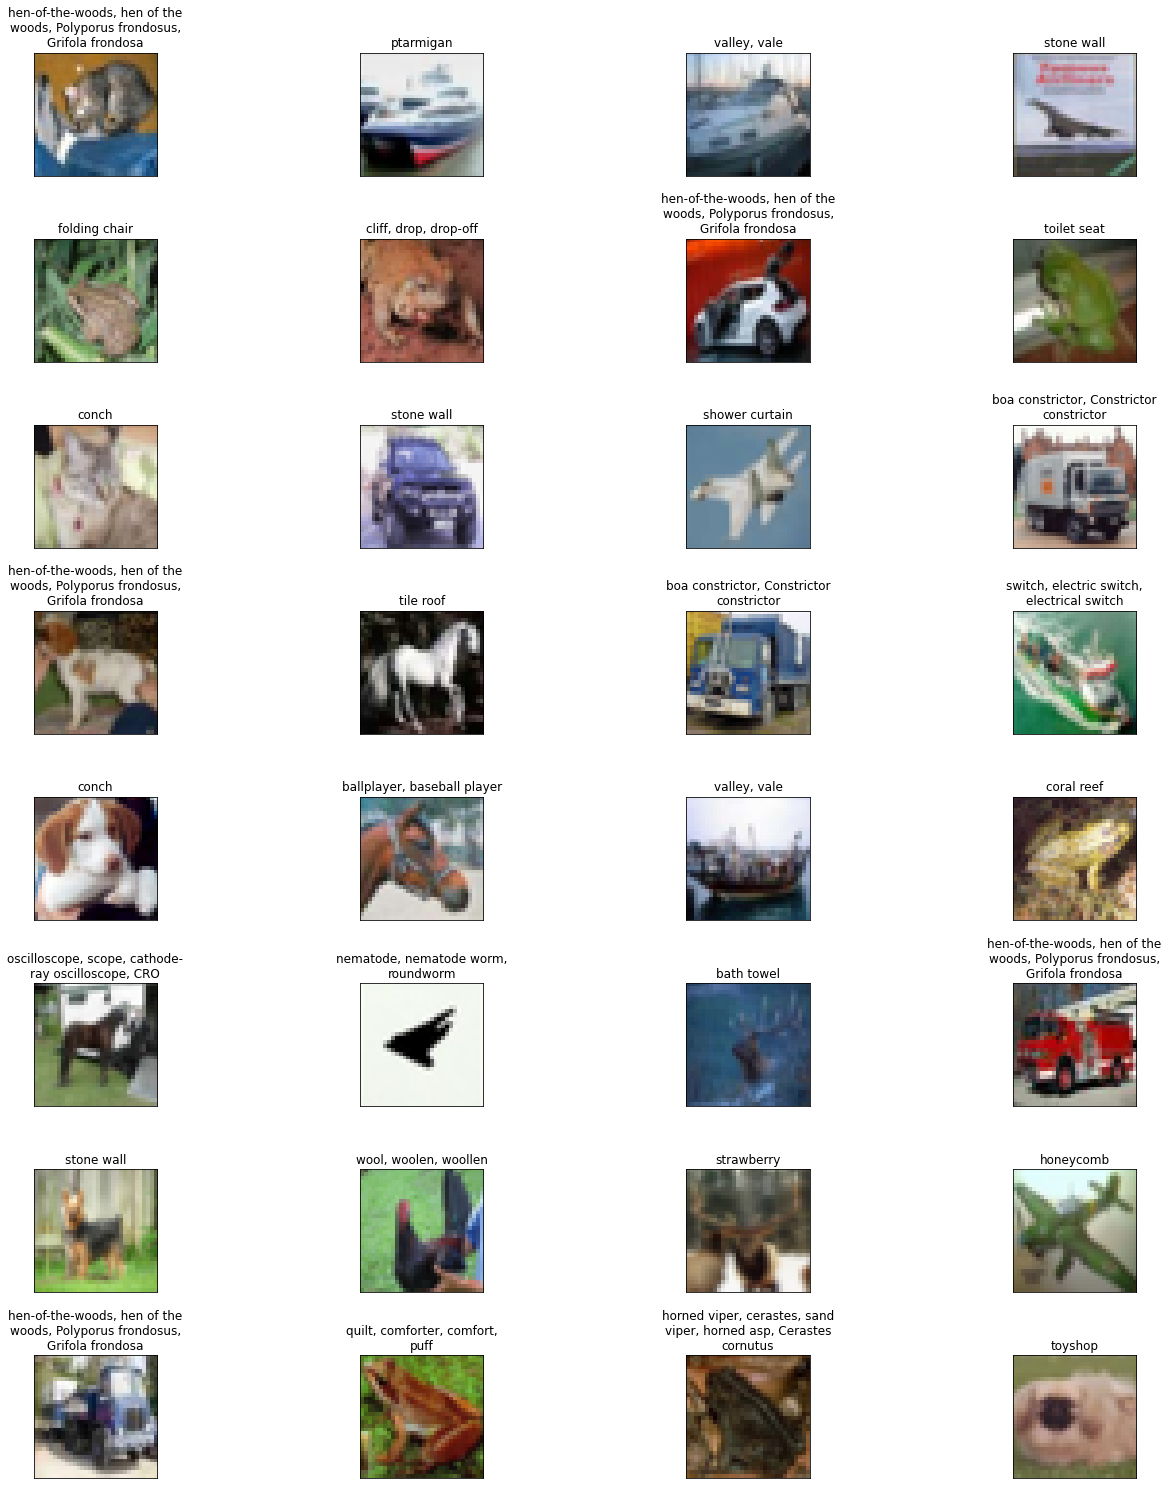

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# select one image, unsqueezing axis 0 to make input batch of one image
_images = images.to(device)
# must set eval model for batch of one image, or model crashes
mobilenet.eval()
with torch.no_grad():
    outputs = mobilenet(_images)
mobilenet.train()
# model ouptputs to imagenet labels
imagenet_idx_to_label
_, indices = outputs.max(1)
indices = indices.cpu().numpy()
labels = [imagenet_idx_to_label[i] for i in indices]
batchsize = images.shape[0]
fig, axes = plt.subplots(batchsize // 4, 4, figsize=(20, 20))
axes = axes.ravel()
for idx, ax in enumerate(axes):
    image = (images[idx].numpy() / 2 + 0.5).transpose(1, 2, 0)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    title = "\n".join(textwrap.wrap(labels[idx], 30))
    title = ax.set_title(title)
    title.set_y(1.1)
    
fig.tight_layout()
fig.subplots_adjust(top=1)

In [8]:
"""The original MobileNet V3 (small) classifier has this form
Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)
"""
mobilenet.classifier = nn.Sequential(*[
        nn.Linear(in_features=576, out_features=1024, bias=True),
        nn.Hardswish(),
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1024, out_features=args.output_size, bias=True),]).to(device)

## Re-training MobileNet 

Training Epoch 1:   0%|                                                     | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Test accuracy: 60.94%


Training Epoch 2:   0%|                                                     | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Test accuracy: 65.39%


Training Epoch 3:   0%|                                                     | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Test accuracy: 67.63%


Training Epoch 4:   0%|                                                     | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Test accuracy: 67.90%


Training Epoch 5:   0%|                                                     | 0/1563 [00:00<?, ?it/s]

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Test accuracy: 68.05%
Done.
Training time took 130.58189153671265 seconds


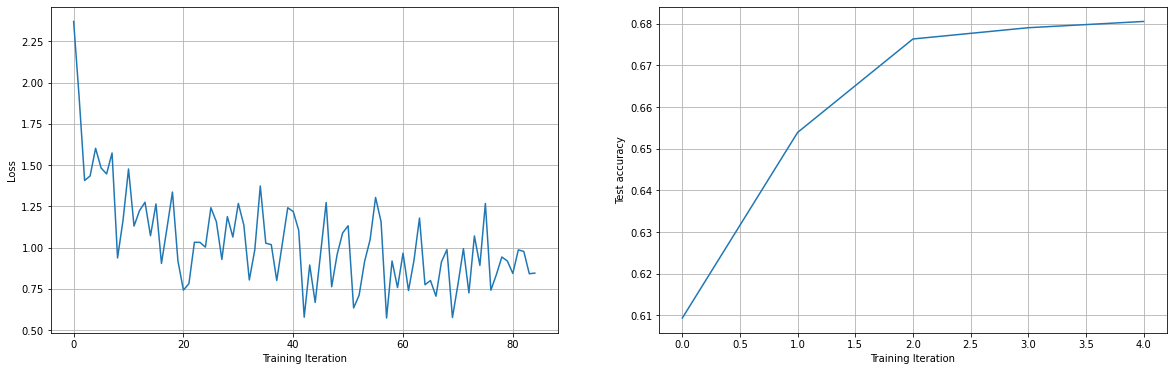

In [9]:
loss_over_time = []
acc_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.learning_rate, momentum=0.9)
#     optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.97)
#     scheduler = None
    
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Test accuracy: {:1.2%}".format(correct / total))
        acc_over_time.append(correct / total)
        if scheduler:
            scheduler.step()
    print("Done.")

should_create_new_instance = True
if should_create_new_instance:
    start = time.time()
    train(mobilenet, args, trainloader, testloader)
    end = time.time()
    print(f"Training time took {end - start} seconds")
    torch.save(mobilenet.state_dict(), './models/cifar_mobilenet.pth')
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes = axes.ravel()
    axes[0].plot(range(len(loss_over_time)), loss_over_time)
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Training Iteration")
    axes[0].grid()
    axes[1].plot(range(len(acc_over_time)), acc_over_time)
    axes[1].set_ylabel("Test accuracy")
    axes[1].set_xlabel("Training Iteration")
    axes[1].grid()
    
else:
    net.load_state_dict(torch.load('./models/cifar_mobilenet.pth'))

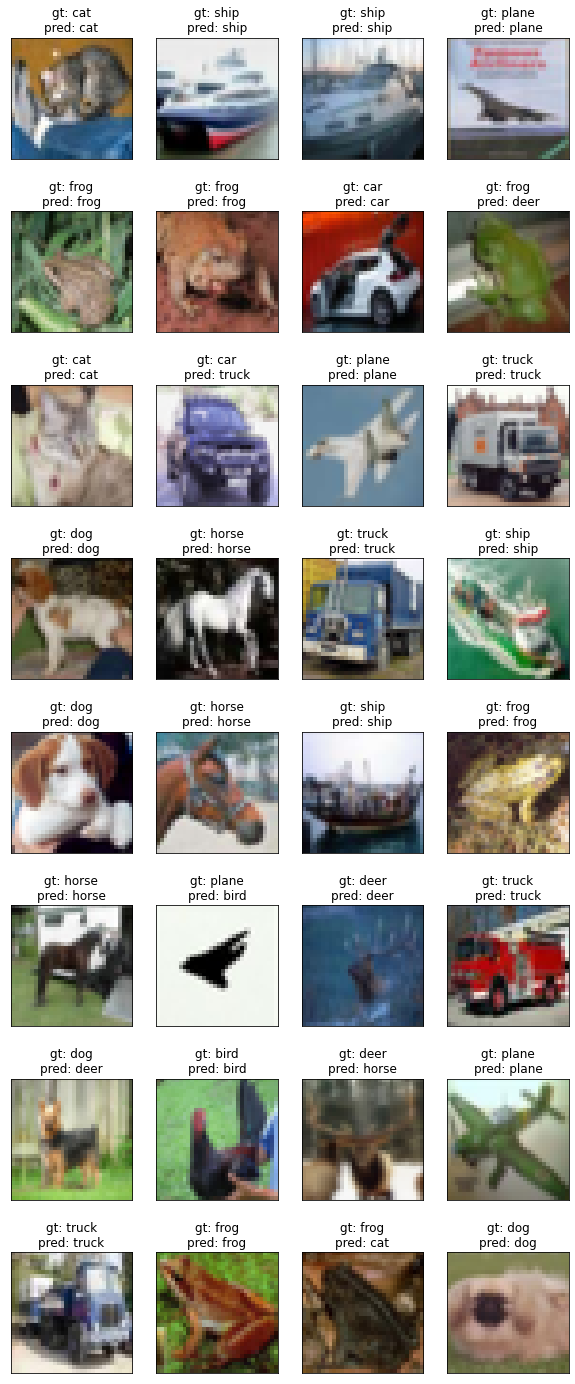

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

_images = images.to(device)
outputs = mobilenet(_images)
_, predicted = torch.max(outputs, 1)

# print images
# imshow(torchvision.utils.make_grid(images))
# get labels
ground_truth = [classes[labels[j]] for j in range(args.batch_size)]
predictions = [classes[predicted[j]] for j in range(args.batch_size)]

df = pd.DataFrame({
    'GroundTruth': ground_truth,
    'Prediction': predictions
})

images = images.numpy()
n_rows = args.batch_size // 4 + int((args.batch_size % 4) > 0)
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 25))
axes = axes.ravel()
for idx, image in enumerate(images):
    image = image / 2 + 0.5
    image = image.transpose((1, 2, 0))
    axes[idx].imshow(image)
    title = "gt: {}\npred: {}".format(df.at[idx, 'GroundTruth'], df.at[idx, 'Prediction'])
    axes[idx].set_title(title)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = mobilenet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 67 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    mobilenet.eval()
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    mobilenet.train()


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Evaluating:   0%|                                                            | 0/313 [00:00<?, ?it/s]

Accuracy for class plane is: 68.1 %
Accuracy for class car   is: 74.7 %
Accuracy for class bird  is: 59.8 %
Accuracy for class cat   is: 57.5 %
Accuracy for class deer  is: 64.3 %
Accuracy for class dog   is: 54.6 %
Accuracy for class frog  is: 79.8 %
Accuracy for class horse is: 78.2 %
Accuracy for class ship  is: 83.9 %
Accuracy for class truck is: 78.8 %
